<a href="https://colab.research.google.com/github/rliu7926/weinstein-ligo-research/blob/main/2.2%20GW%20Signal%20Detection%20Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Random Noise Simulation

This notebook corresponds with section 2.2 of the overview: random noise generator. 

In [ ]:
## Install packages and initialize environment
! pip install -q 'lalsuite==6.66' 'PyCBC==1.15.3' 

%matplotlib inline
import numpy
import pylab
import pycbc
from pycbc.waveform import get_td_waveform
import pycbc.noise
import pycbc.psd

In [ ]:
def create_waveform(mass1, mass2, resolution, frequencybound, distance):
  
  redshift = 1 + 72*distance/(299792.458-72*distance)
  
  waveform, waveform_cross = get_td_waveform(approximant="SEOBNRv4_opt",
                                             mass1=mass1,
                                             mass2=mass1,
                                             delta_t=resolution/redshift,
                                             f_lower=frequencybound)
  
  waveform_amplitude = [0.0] * len(waveform)
  waveform_time = [0.0] * len(waveform)

  for i in range(0, len(waveform)-1):
    waveform_amplitude[i] = waveform[i]
    waveform_time[i] = waveform.sample_times[i]

  waveform_amplitude = [i/distance for i in waveform_amplitude]
  waveform_time = [i*redshift for i in waveform_time]

  waveform_amplitude = numpy.array(waveform_amplitude)
  waveform_time = numpy.array(waveform_time)

  return waveform_amplitude, waveform_time
  

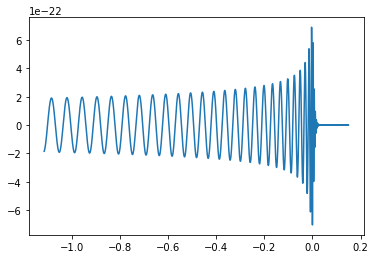

In [ ]:
## Create GW signal for m = 30 solar masses

gw30amp1000, gw30time1000 = create_waveform(mass1 = 30, 
                             mass2 = 30, 
                             resolution = 1.0/4096, 
                             frequencybound = 20, 
                             distance = 1000)

pylab.plot(gw30time1000, gw30amp1000)

['AdVBNSOptimizedSensitivityP1200087', 'AdVDesignSensitivityP1200087', 'AdVEarlyHighSensitivityP1200087', 'AdVEarlyLowSensitivityP1200087', 'AdVLateHighSensitivityP1200087', 'AdVLateLowSensitivityP1200087', 'AdVMidHighSensitivityP1200087', 'AdVMidLowSensitivityP1200087', 'AdvVirgo', 'CosmicExplorerP1600143', 'CosmicExplorerPessimisticP1600143', 'CosmicExplorerWidebandP1600143', 'EinsteinTelescopeP1600143', 'GEO', 'GEOHF', 'KAGRA', 'KAGRADesignSensitivityT1600593', 'KAGRAEarlySensitivityT1600593', 'KAGRALateSensitivityT1600593', 'KAGRAMidSensitivityT1600593', 'KAGRAOpeningSensitivityT1600593', 'TAMA', 'Virgo', 'aLIGOAPlusDesignSensitivityT1800042', 'aLIGOAdVO3LowT1800545', 'aLIGOAdVO4IntermediateT1800545', 'aLIGOAdVO4T1800545', 'aLIGOBHBH20Deg', 'aLIGOBHBH20DegGWINC', 'aLIGOBNSOptimizedSensitivityP1200087', 'aLIGODesignSensitivityP1200087', 'aLIGOEarlyHighSensitivityP1200087', 'aLIGOEarlyLowSensitivityP1200087', 'aLIGOHighFrequency', 'aLIGOHighFrequencyGWINC', 'aLIGOKAGRA128MpcT1800545'

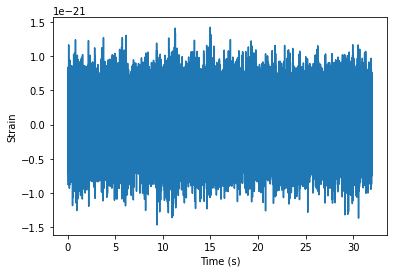

In [ ]:
## Generate a list of all possible built-in PSDs
print(pycbc.psd.get_lalsim_psd_list())

## Generate frequency series PSD for aLIGO design sensitivity 

low_freq = 10
resolution = 1.0/4096
samples = int(4096 / resolution) + 1

aLIGOdesignpsd = pycbc.psd.from_string(psd_name = 'aLIGODesignSensitivityP1200087',
                                       length = samples,
                                       delta_f = resolution, 
                                       low_freq_cutoff = low_freq)

## Generate 32 seconds of Gaussian noise at 4096 Hz

interval = 1.0/4096
timesamples = int(32 / interval)
aLIGOdesignnoise = pycbc.noise.noise_from_psd(length = timesamples, 
                                         delta_t = interval,
                                         psd = aLIGOdesignpsd,
                                         seed = 127)

pylab.plot(aLIGOdesignnoise.sample_times, aLIGOdesignnoise)
pylab.ylabel('Strain')
pylab.xlabel('Time (s)')
pylab.show()



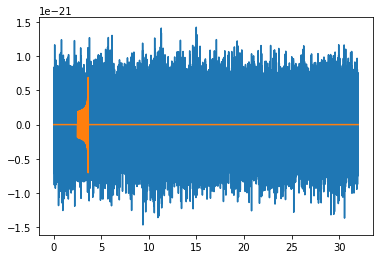

In [ ]:
## Add GW signal to the data

# Resize GW signal to the length of the random noise sample

from random import randint
timeshift = randint(0, len(aLIGOdesignnoise)-len(gw30amp1000)) # Add a random timeshift
gw30amp1000 = numpy.append([0] * timeshift, gw30amp1000) # Append zeroes before the wave
gw30amp1000 = numpy.append(gw30amp1000, [0] * (len(aLIGOdesignnoise)-len(gw30amp1000))) # Append zeroes after the wave 
gw30time1000 = aLIGOdesignnoise.sample_times

pylab.plot(aLIGOdesignnoise.sample_times, aLIGOdesignnoise)
pylab.plot(gw30time1000, gw30amp1000)


A signal was found at 3.617919921875 s with SNR 17.65256960734215.
The redshifted waveform was inserted at time 0.0 s.


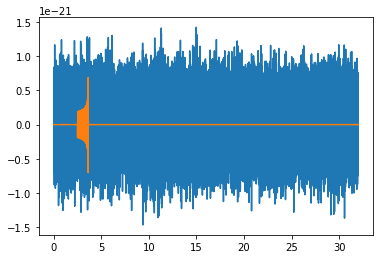

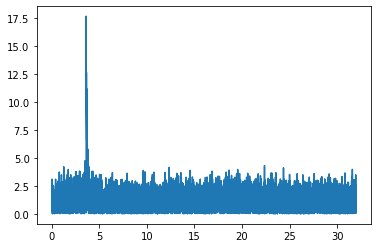

In [ ]:
## Add the waveform to the generated noise

gw30noise1000 = aLIGOdesignnoise + gw30amp1000

pylab.plot(aLIGOdesignnoise.sample_times, gw30noise1000)
pylab.plot(gw30time1000, gw30amp1000)

## Calculate the SNR time series 

from pycbc.filter import matched_filter

waveform_template, waveform_template_cross = get_td_waveform(approximant="SEOBNRv4_opt",
                                                             mass1=30,
                                                             mass2=30,
                                                             delta_t=1.0/4096, 
                                                             f_lower=20)

waveform_template.resize(len(aLIGOdesignnoise))
waveform_template = waveform_template.cyclic_time_shift(waveform_template.start_time)

from pycbc.psd import interpolate, inverse_spectrum_truncation

psd = gw30noise1000.psd(4)
psd = interpolate(psd, gw30noise1000.delta_f)
psd = inverse_spectrum_truncation(psd, 4*gw30noise1000.sample_rate, low_frequency_cutoff=20)

gw30snr1000 = matched_filter(template=waveform_template,
                             data=gw30noise1000,
                             psd = psd,
                             low_frequency_cutoff=20, high_frequency_cutoff=2000)

pylab.figure()
pylab.plot(gw30snr1000.sample_times, abs(gw30snr1000))

gw30snr1000peak = abs(gw30snr1000).numpy().argmax()
gw30snr1000peakvalue = gw30snr1000[gw30snr1000peak]
gw30snr1000peaktime = gw30snr1000.sample_times[gw30snr1000peak]

print("A signal was found at {} s with SNR {}.".format(gw30snr1000peaktime, abs(gw30snr1000peakvalue)))
print("The redshifted waveform was inserted at time {} s.".format(timeshift/4096))

In [ ]:
## Create function to automate above

def determine_SNR(mass1, mass2, waveformmass1, waveformmass2, resolution, frequencybound, psdresolution, distance, noise, noisetime):

  gwamp, gwtime = create_waveform(mass1, mass2, resolution, frequencybound, distance)

  # Generate the frequency series PSD

  samples = int(4096 / psdresolution) + 1

  designpsd = pycbc.psd.from_string(psd_name = noise,
                                         length = samples,
                                         delta_f = psdresolution, 
                                         low_freq_cutoff = frequencybound)

  # Generate [noisetime] seconds of Gaussian noise at [1/resolution] Hz

  timesamples = int(noisetime / resolution)
  gaussiannoise = pycbc.noise.gaussian.noise_from_psd(length = timesamples, 
                                                      delta_t = resolution,
                                                      psd = designpsd,
                                                      seed = None)
  
  # Resize GW signal to the length of the random noise sample

  timeshift = randint(0, len(gaussiannoise)-len(gwamp)) # Add a random timeshift
  gwamp = numpy.append([0] * timeshift, gwamp) # Append zeroes before the wave
  gwamp = numpy.append(gwamp, [0] * (len(gaussiannoise)-len(gwamp))) # Append zeroes after the wave 
  gwtime = gaussiannoise.sample_times

  ## Add the waveform to the generated noise

  gwnoise = gaussiannoise + gwamp

  ## Calculate the SNR time series 

  waveform_template, waveform_template_cross = get_td_waveform(approximant="SEOBNRv4_opt",
                                                               mass1=waveformmass1,
                                                               mass2=waveformmass2,
                                                               delta_t=resolution, 
                                                               f_lower=frequencybound)

  waveform_template.resize(len(gaussiannoise))
  waveform_template = waveform_template.cyclic_time_shift(waveform_template.start_time)

  ## Calculate and plot the SNR
  psd = gwnoise.psd(4)
  psd = interpolate(psd, gwnoise.delta_f)
  psd = inverse_spectrum_truncation(psd, 4*gwnoise.sample_rate, low_frequency_cutoff=frequencybound)

  gwsnr = matched_filter(template=waveform_template,
                         data=gwnoise,
                         psd = psd,
                         low_frequency_cutoff=frequencybound)
  
  pylab.figure()
  pylab.plot(gwsnr.sample_times, abs(gwsnr))

  gwsnrpeak = abs(gwsnr).numpy().argmax()
  gwsnrpeakvalue = gwsnr[gwsnrpeak]
  gwsnrpeaktime = gwsnr.sample_times[gwsnrpeak]

  print("A signal was found at {} s with SNR {}.".format(gwsnrpeaktime, abs(gwsnrpeakvalue)))
  print("The redshifted waveform was inserted at time {} s.".format(timeshift*resolution))

  return(abs(gwsnrpeakvalue))


A signal was found at 5.8291015625 s with SNR 69.04668544325362.
The redshifted waveform was inserted at time 5.26708984375 s.
A signal was found at 11.173828125 s with SNR 30.539684060718624.
The redshifted waveform was inserted at time 10.521484375 s.
A signal was found at 27.9345703125 s with SNR 19.38930272886293.
The redshifted waveform was inserted at time 27.1572265625 s.
A signal was found at 11.0166015625 s with SNR 11.537108605360121.
The redshifted waveform was inserted at time 10.05517578125 s.


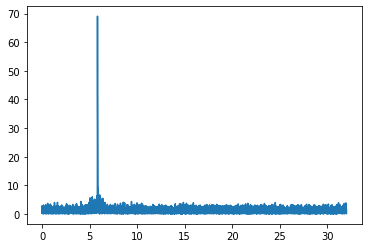

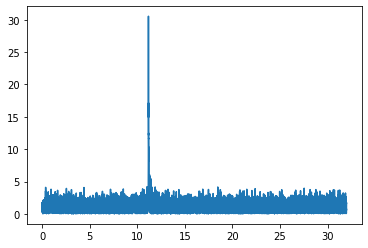

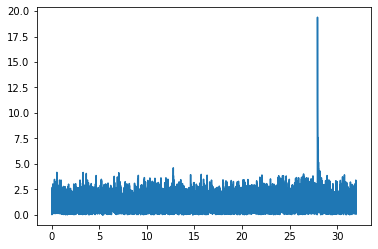

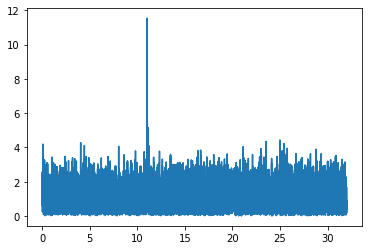

In [ ]:
## Test out function

snr40d500 = determine_SNR(mass1=40, mass2=40, 
              waveformmass1=40, waveformmass2=40,
              resolution=1.0/2048, frequencybound=20, psdresolution=1.0/16,
              distance=500, noise='aLIGODesignSensitivityP1200087', noisetime=32)


snr40d1000 = determine_SNR(mass1=40, mass2=40, 
              waveformmass1=40, waveformmass2=40,
              resolution=1.0/2048, frequencybound=20, psdresolution=1.0/16,
              distance=1000, noise='aLIGODesignSensitivityP1200087', noisetime=32)


snr40d1500 = determine_SNR(mass1=40, mass2=40, 
              waveformmass1=40, waveformmass2=40,
              resolution=1.0/2048, frequencybound=20, psdresolution=1.0/16,
              distance=1500, noise='aLIGODesignSensitivityP1200087', noisetime=32)


snr40d2000 = determine_SNR(mass1=40, mass2=40, 
              waveformmass1=40, waveformmass2=40,
              resolution=1.0/2048, frequencybound=20, psdresolution=1.0/16,
              distance=2000, noise='aLIGODesignSensitivityP1200087', noisetime=32)

A signal was found at 12.1005859375 s with SNR 452.76583074104934.
The redshifted waveform was inserted at time 11.59619140625 s.
A signal was found at 13.30859375 s with SNR 322.07241917130324.
The redshifted waveform was inserted at time 12.4384765625 s.
A signal was found at 29.76953125 s with SNR 195.27010212180008.
The redshifted waveform was inserted at time 27.94384765625 s.
A signal was found at 23.5673828125 s with SNR 202.97656451910765.
The redshifted waveform was inserted at time 23.04931640625 s.
A signal was found at 11.2734375 s with SNR 139.08493284677695.
The redshifted waveform was inserted at time 10.380859375 s.
A signal was found at 11.79443359375 s with SNR 81.29810598640097.
The redshifted waveform was inserted at time 9.92236328125 s.
A signal was found at 5.3525390625 s with SNR 126.80853933413549.
The redshifted waveform was inserted at time 4.82080078125 s.
A signal was found at 17.90234375 s with SNR 87.83183944326755.
The redshifted waveform was inserted at

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 11.27685546875 s with SNR 12.507941788176385.
The redshifted waveform was inserted at time 9.1337890625 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 20.43408203125 s with SNR 42.1116255626333.
The redshifted waveform was inserted at time 19.82080078125 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 4.48681640625 s with SNR 24.930913141423794.
The redshifted waveform was inserted at time 3.4326171875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 5.17578125 s with SNR 10.881903699993227.
The redshifted waveform was inserted at time 2.96923828125 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 21.55908203125 s with SNR 37.58752105548485.
The redshifted waveform was inserted at time 20.9267578125 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 1.205078125 s with SNR 21.80751034828637.
The redshifted waveform was inserted at time 0.119140625 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 28.57080078125 s with SNR 10.940881907156149.
The redshifted waveform was inserted at time 26.29638671875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 14.0029296875 s with SNR 32.98278758634295.
The redshifted waveform was inserted at time 13.35009765625 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 17.5380859375 s with SNR 16.36340836066194.
The redshifted waveform was inserted at time 16.4169921875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 25.91748046875 s with SNR 8.321616582395391.
The redshifted waveform was inserted at time 23.57080078125 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 11.2998046875 s with SNR 26.178632176429677.
The redshifted waveform was inserted at time 10.625 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 22.64794921875 s with SNR 15.864885547331461.
The redshifted waveform was inserted at time 21.490234375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 21.84912109375 s with SNR 6.551775051769389.
The redshifted waveform was inserted at time 19.396484375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 15.2490234375 s with SNR 24.76389428039694.
The redshifted waveform was inserted at time 14.55078125 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 20.3720703125 s with SNR 14.676306690453918.
The redshifted waveform was inserted at time 19.1748046875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 4.5732421875 s with SNR 7.87672306628547.
The redshifted waveform was inserted at time 2.06787109375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 11.580078125 s with SNR 23.398535952214974.
The redshifted waveform was inserted at time 10.857421875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 4.533203125 s with SNR 12.014851493767669.
The redshifted waveform was inserted at time 3.29345703125 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 24.4189453125 s with SNR 6.615539242287527.
The redshifted waveform was inserted at time 21.81201171875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 17.0107421875 s with SNR 18.64418128888608.
The redshifted waveform was inserted at time 16.26123046875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 6.9267578125 s with SNR 11.577294230704881.
The redshifted waveform was inserted at time 5.6416015625 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 26.9248046875 s with SNR 7.356841603556426.
The redshifted waveform was inserted at time 24.23681640625 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 7.05322265625 s with SNR 18.139419895113534.
The redshifted waveform was inserted at time 6.2744140625 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 14.49951171875 s with SNR 11.74852748273446.
The redshifted waveform was inserted at time 13.166015625 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 14.4091796875 s with SNR 5.931906650429343.
The redshifted waveform was inserted at time 11.62060546875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 20.173828125 s with SNR 17.365233589671643.
The redshifted waveform was inserted at time 19.365234375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 25.41650390625 s with SNR 11.60593704745982.
The redshifted waveform was inserted at time 24.02978515625 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 20.80859375 s with SNR 5.249019261921517.
The redshifted waveform was inserted at time 27.177734375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 17.06396484375 s with SNR 14.869410186408.
The redshifted waveform was inserted at time 16.220703125 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 27.43994140625 s with SNR 9.153461126628736.
The redshifted waveform was inserted at time 25.99658203125 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 31.8486328125 s with SNR 4.741906120625441.
The redshifted waveform was inserted at time 14.96875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 11.68017578125 s with SNR 13.347627192795349.
The redshifted waveform was inserted at time 10.80224609375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 13.21630859375 s with SNR 8.26774480363857.
The redshifted waveform was inserted at time 11.7138671875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 14.49462890625 s with SNR 5.075133790085361.
The redshifted waveform was inserted at time 1.326171875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 19.9912109375 s with SNR 12.2133210505642.
The redshifted waveform was inserted at time 19.076171875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 23.16162109375 s with SNR 8.866417259541295.
The redshifted waveform was inserted at time 21.58935546875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 12.06787109375 s with SNR 6.241890944415989.
The redshifted waveform was inserted at time 8.78564453125 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 30.30517578125 s with SNR 12.249930345079425.
The redshifted waveform was inserted at time 29.3466796875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 22.90625 s with SNR 8.385870716393173.
The redshifted waveform was inserted at time 21.26171875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 27.4365234375 s with SNR 4.99065450888812.
The redshifted waveform was inserted at time 20.5146484375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 3.029296875 s with SNR 12.196466102598698.
The redshifted waveform was inserted at time 2.021484375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 20.521484375 s with SNR 7.632424691937011.
The redshifted waveform was inserted at time 18.79443359375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 28.29443359375 s with SNR 4.723222008015067.
The redshifted waveform was inserted at time 24.43310546875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 28.16796875 s with SNR 11.228877360963777.
The redshifted waveform was inserted at time 27.109375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 25.265625 s with SNR 6.802276846246411.
The redshifted waveform was inserted at time 23.451171875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 10.162109375 s with SNR 4.646702833301023.
The redshifted waveform was inserted at time 1.1943359375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 4.29541015625 s with SNR 11.96213334692128.
The redshifted waveform was inserted at time 3.17529296875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 20.138671875 s with SNR 5.707315514163439.
The redshifted waveform was inserted at time 18.232421875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 28.85546875 s with SNR 4.868735369402064.
The redshifted waveform was inserted at time 19.10546875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 25.46533203125 s with SNR 9.589061349394864.
The redshifted waveform was inserted at time 24.2841796875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 23.2529296875 s with SNR 6.746267286818893.
The redshifted waveform was inserted at time 21.23193359375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 24.44189453125 s with SNR 4.340144054924452.
The redshifted waveform was inserted at time 8.95849609375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 28.5126953125 s with SNR 10.226502008935952.
The redshifted waveform was inserted at time 27.25732421875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 28.03271484375 s with SNR 5.5919516166252645.
The redshifted waveform was inserted at time 12.568359375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 30.08984375 s with SNR 5.0037111546895465.
The redshifted waveform was inserted at time 19.3818359375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 20.99365234375 s with SNR 8.7333149689487.
The redshifted waveform was inserted at time 19.6552734375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 24.57421875 s with SNR 5.686518745519501.
The redshifted waveform was inserted at time 22.2978515625 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 24.03369140625 s with SNR 5.686080391188584.
The redshifted waveform was inserted at time 19.26904296875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 26.5400390625 s with SNR 6.734402532003762.
The redshifted waveform was inserted at time 25.109375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 24.333984375 s with SNR 5.5508844571934315.
The redshifted waveform was inserted at time 21.89208984375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 14.8974609375 s with SNR 5.180300201581037.
The redshifted waveform was inserted at time 9.81591796875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 27.46337890625 s with SNR 7.31007001926418.
The redshifted waveform was inserted at time 25.9267578125 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 21.33154296875 s with SNR 5.187863817838036.
The redshifted waveform was inserted at time 18.71728515625 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 7.861328125 s with SNR 4.7523672889336925.
The redshifted waveform was inserted at time 8.0302734375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 3.09423828125 s with SNR 6.161968477994717.
The redshifted waveform was inserted at time 1.43310546875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 29.4130859375 s with SNR 4.960430078739864.
The redshifted waveform was inserted at time 26.54736328125 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 6.3115234375 s with SNR 4.887120487753317.
The redshifted waveform was inserted at time 5.8037109375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 3.927734375 s with SNR 6.712493791208172.
The redshifted waveform was inserted at time 2.1142578125 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 5.8955078125 s with SNR 5.813020560274186.
The redshifted waveform was inserted at time 2.82568359375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 10.8154296875 s with SNR 4.579227110645068.
The redshifted waveform was inserted at time 9.07080078125 s.


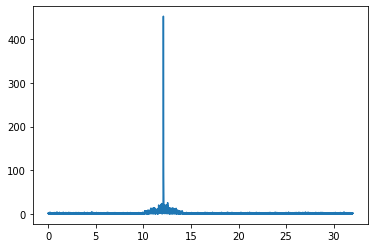

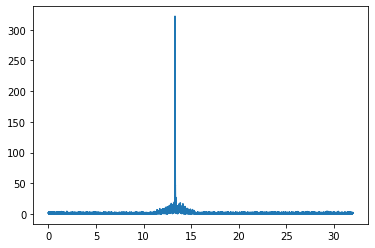

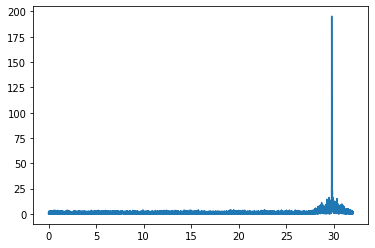

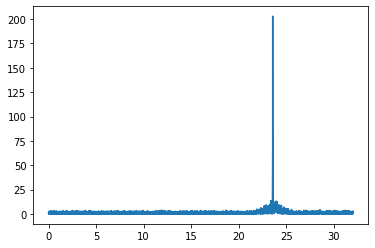

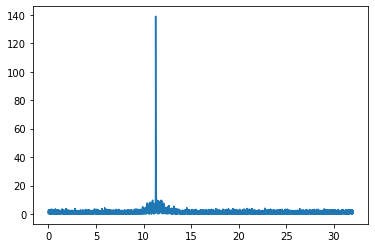

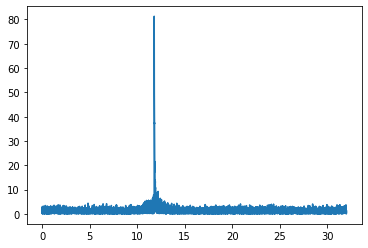

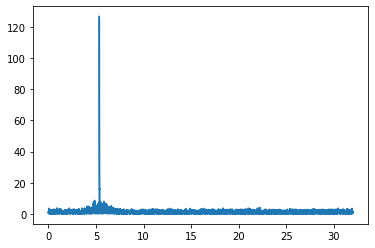

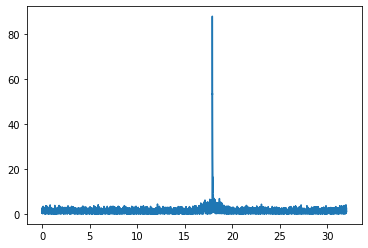

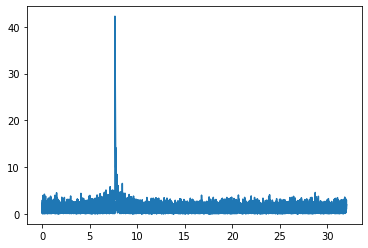

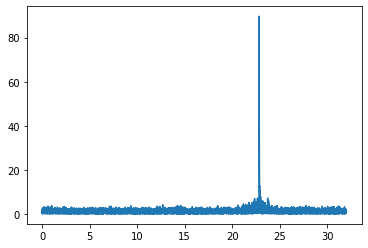

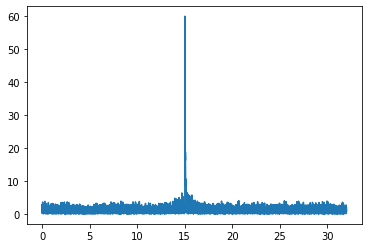

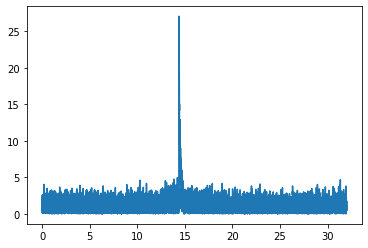

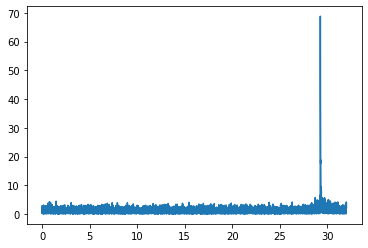

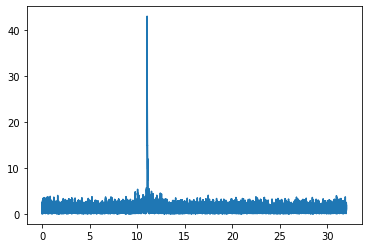

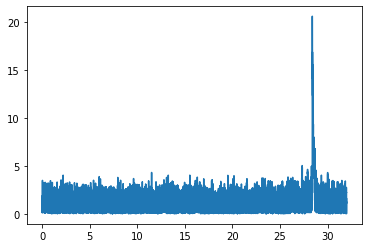

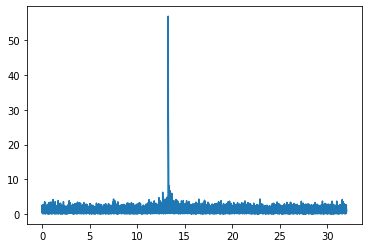

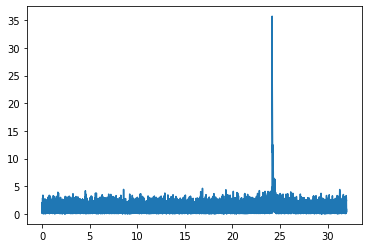

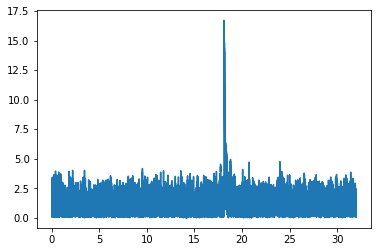

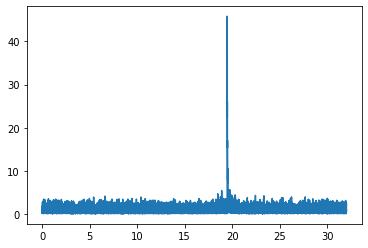

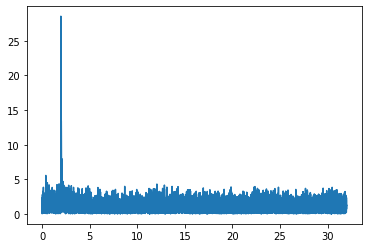

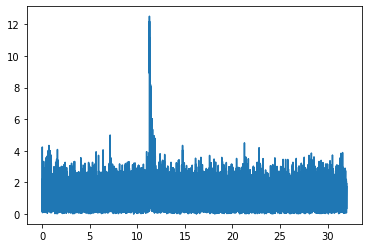

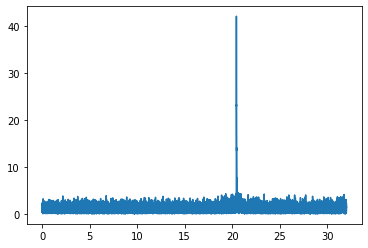

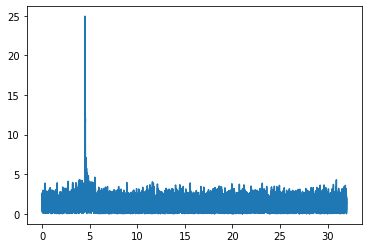

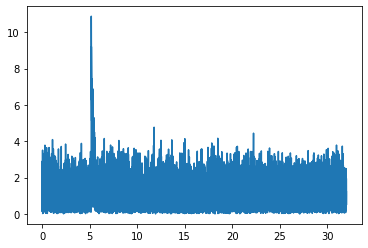

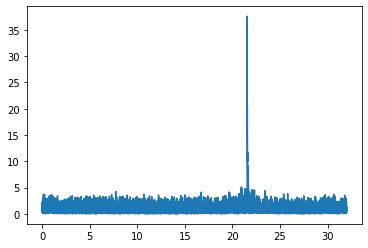

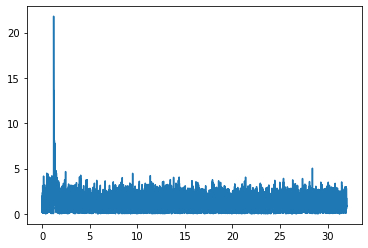

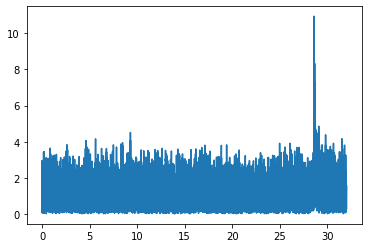

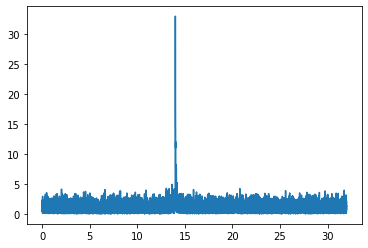

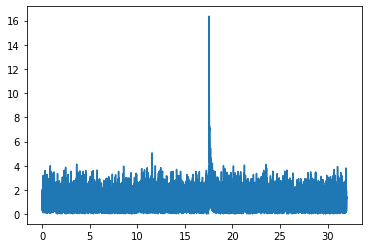

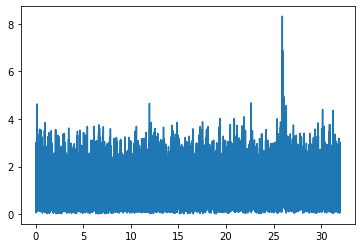

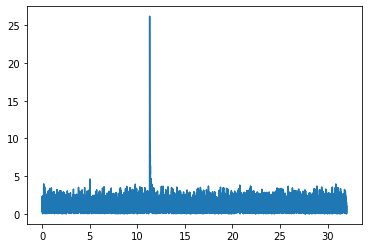

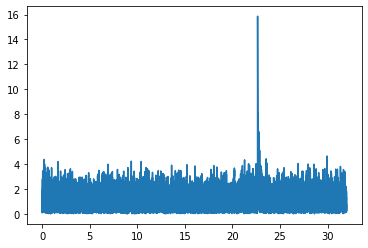

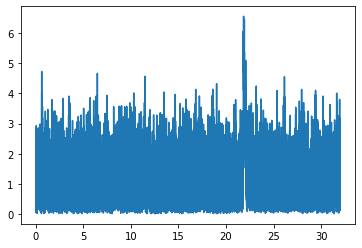

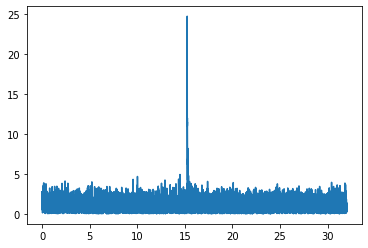

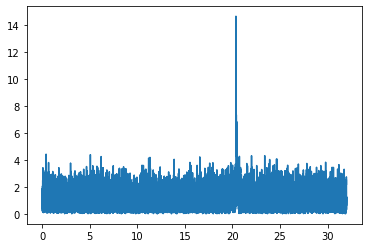

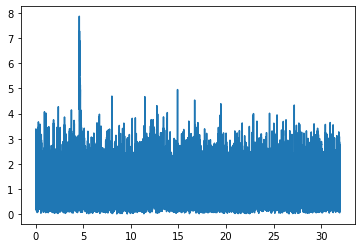

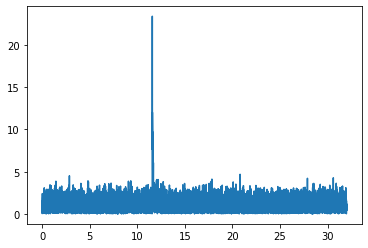

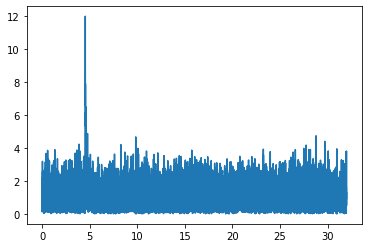

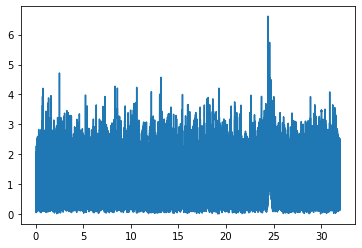

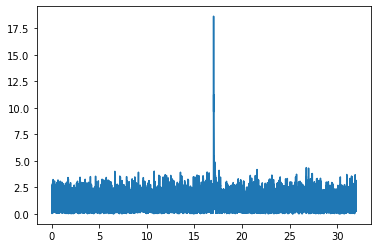

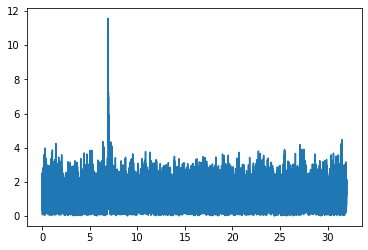

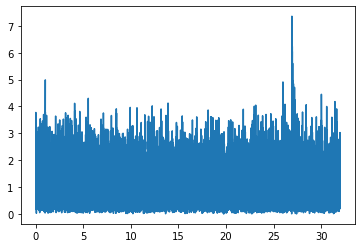

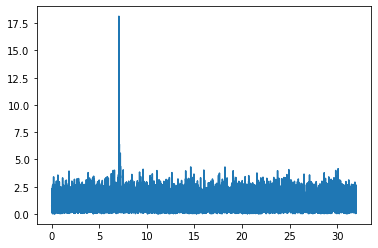

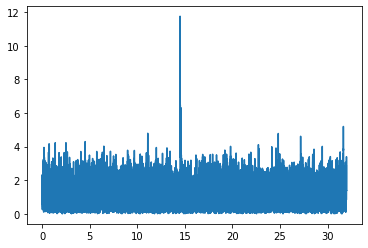

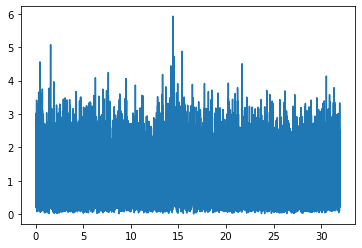

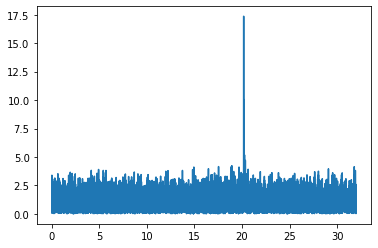

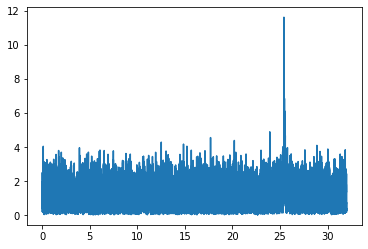

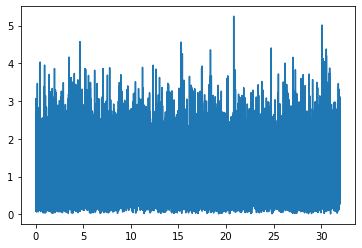

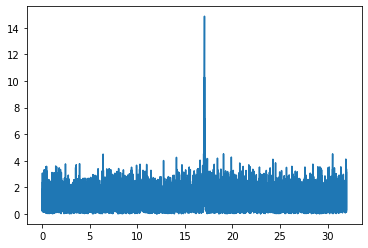

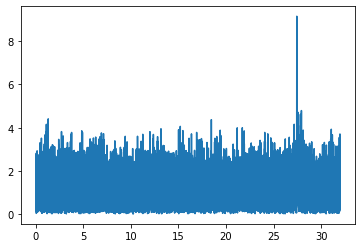

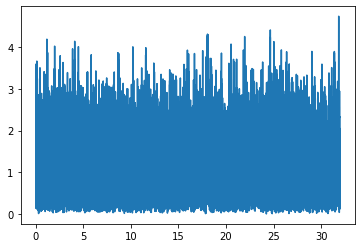

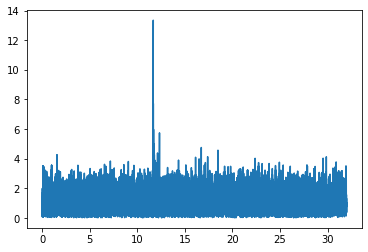

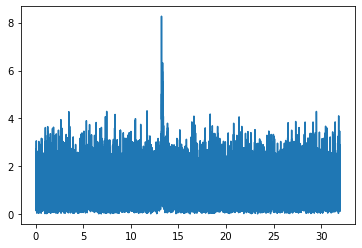

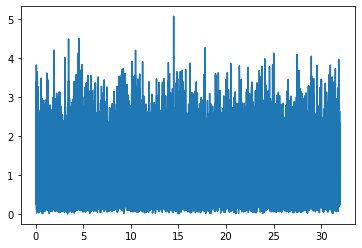

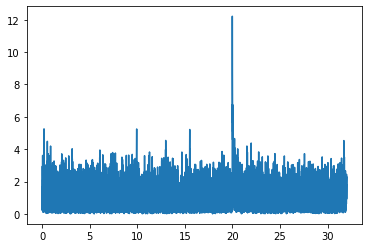

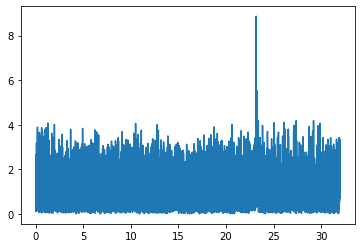

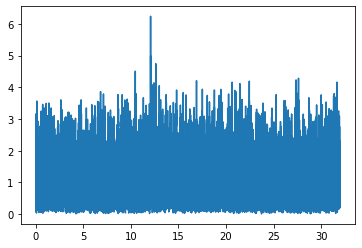

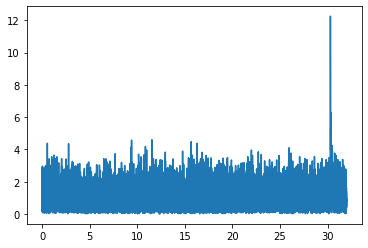

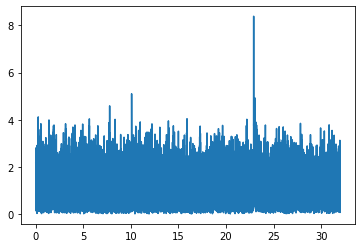

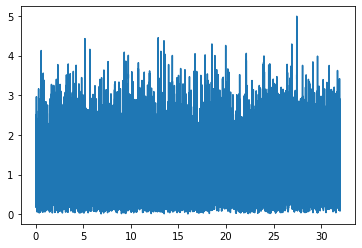

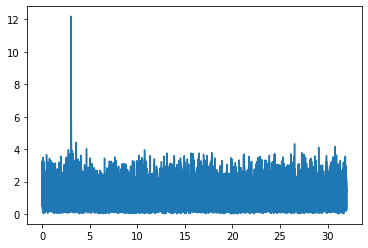

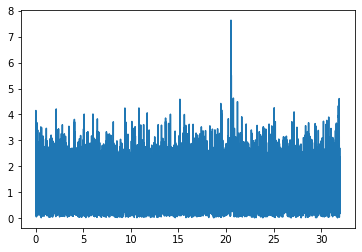

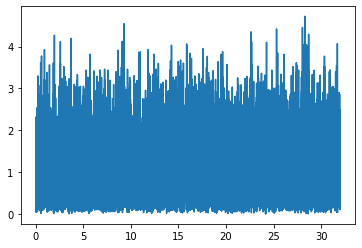

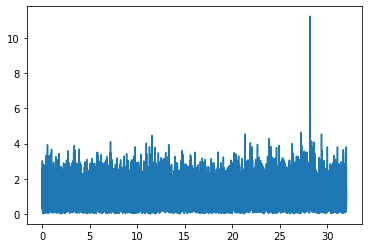

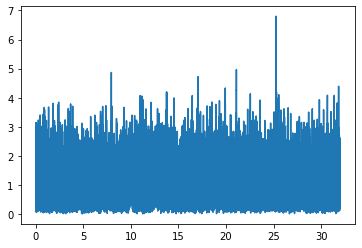

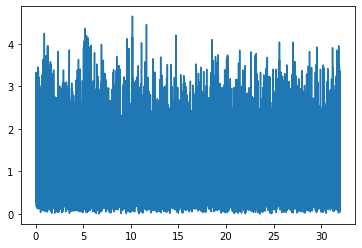

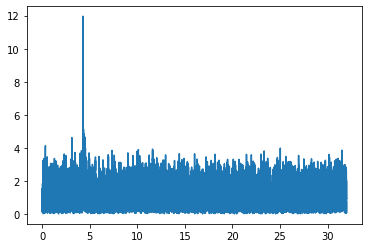

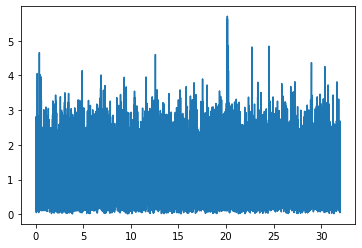

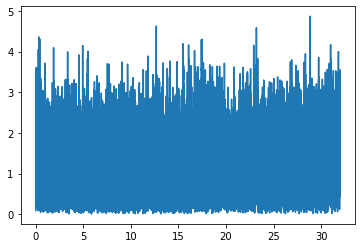

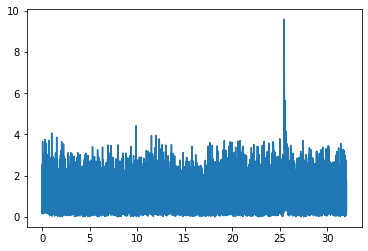

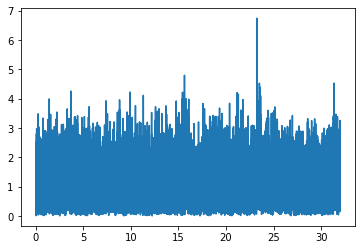

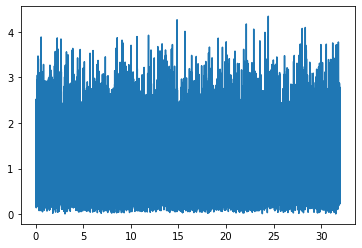

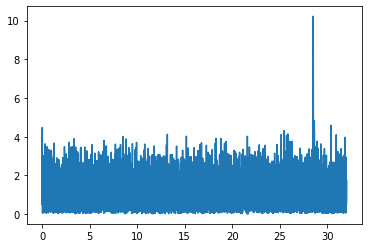

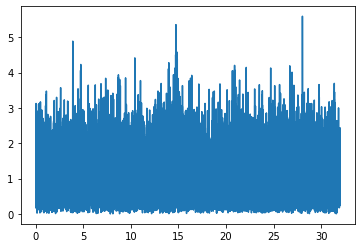

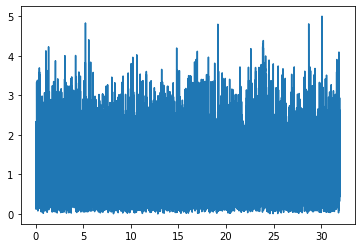

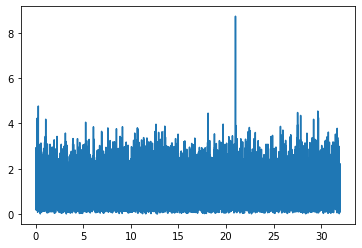

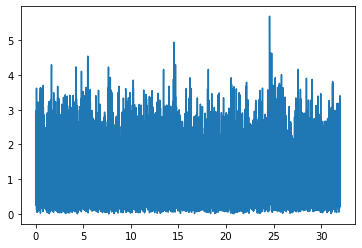

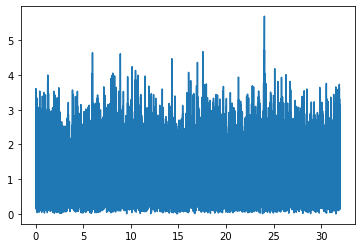

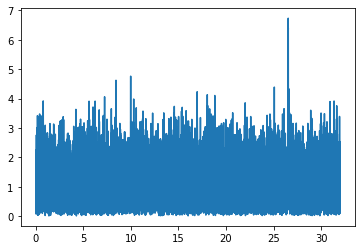

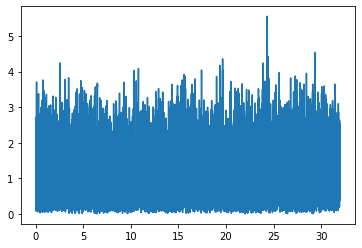

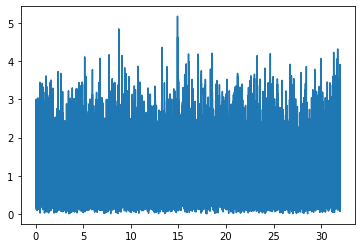

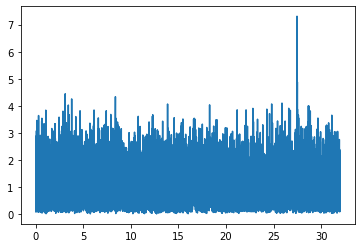

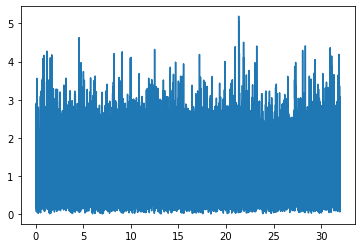

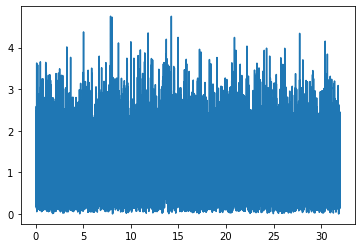

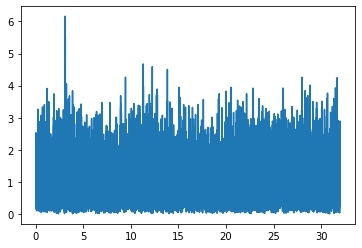

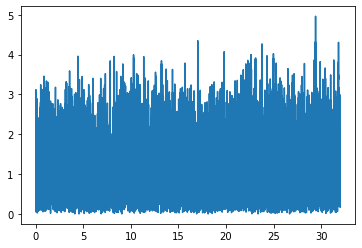

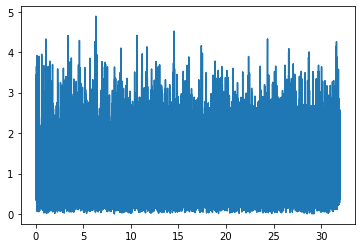

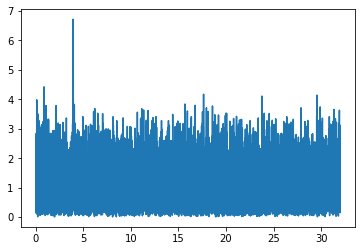

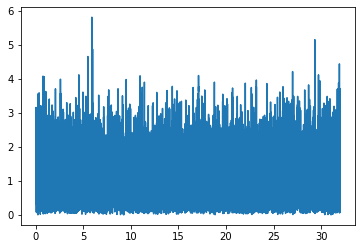

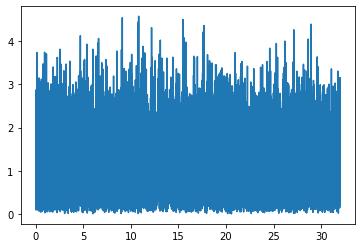

In [ ]:
## Create a graph to plot SNR values for mass = 20, 30, 40 as a function of distance

import numpy as np

distances = np.arange(100, 3100, 100)
snr40 = [0] * 30
snr30 = [0] * 30
snr20 = [0] * 30

index = 0

for distance in distances:
  snr40[index] = determine_SNR(mass1=40, mass2=40, 
                                      waveformmass1=40, waveformmass2=40,
                                      resolution=1.0/2048, frequencybound=20, psdresolution=1.0/16,
                                      distance=distance, noise='aLIGODesignSensitivityP1200087', noisetime=32)
  
  snr30[index] = determine_SNR(mass1=30, mass2=30, 
                                      waveformmass1=30, waveformmass2=30,
                                      resolution=1.0/2048, frequencybound=20, psdresolution=1.0/16,
                                      distance=distance, noise='aLIGODesignSensitivityP1200087', noisetime=32)
  
  snr20[index] = determine_SNR(mass1=20, mass2=20, 
                                      waveformmass1=20, waveformmass2=20,
                                      resolution=1.0/2048, frequencybound=20, psdresolution=1.0/16,
                                      distance=distance, noise='aLIGODesignSensitivityP1200087', noisetime=32)
  
  
  index = index + 1

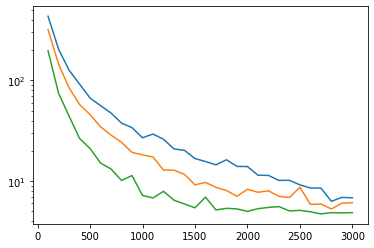

In [ ]:
## Results of above cell 

pylab.plot(distances, snr40)
pylab.plot(distances, snr30)
pylab.plot(distances, snr20)
pylab.yscale('log')
